In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

# library design specific tools
from ImageAnalysis3.library_tools import LibraryDesigner as ld
from ImageAnalysis3.library_tools import LibraryTools as lt
# biopython imports
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML

21052


In [2]:
## Some folders
# human genome
reference_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38'
genome_folder = os.path.join(reference_folder, 'Genome')
# Library directories
pool_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain'
if not os.path.exists(pool_folder):
    print(f"Create pool_folder: {pool_folder}")
    os.makedirs(pool_folder)
else:
    print(f"Use pool_folder: {pool_folder}")

Use pool_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain


In [3]:
# folder for sub-pool
library_folder = os.path.join(pool_folder, f'human_genome_library')
if not os.path.exists(library_folder):
    print(f"create library folder: {library_folder}")
    os.makedirs(library_folder)
# folder for fasta sequences
sequence_folder = os.path.join(library_folder, 'sequences')
if not os.path.exists(sequence_folder):
    print(f"create sequence folder: {sequence_folder}")
    os.makedirs(sequence_folder)
# folder to save result probes
report_folder = os.path.join(library_folder, 'reports')
if not os.path.exists(report_folder):
    print(f"create report folder: {report_folder}")
    os.makedirs(report_folder)
    
print(f"-- library_folder: {library_folder}")
print(f"-- sequence_folder: {sequence_folder}")
print(f"-- report_folder: {report_folder}")

-- library_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library
-- sequence_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences
-- report_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\reports


In [76]:
import pandas as pd
save_folder = os.path.join(library_folder, 'Summary_tables')

if not os.path.exists(save_folder):
    print(f"Create save_folder: {save_folder}")
    os.makedirs(save_folder)
else:
    print(f"Use save_folder: {save_folder}")

Use save_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\Summary_tables


In [7]:
# laod encoding
# summarize total readout usage
encoding_folder = os.path.join(library_folder, f'Encoding_design')
print(encoding_folder)
region_2_bits = pickle.load(open(os.path.join(encoding_folder, 'region_2_bits.pkl'), 'rb'))

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\Encoding_design


In [10]:
# load probes
probes = []
final_pb_filename = os.path.join(library_folder, 'blast_full_probes.fasta')

with open(final_pb_filename, 'r') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        probes.append(record)

In [11]:
# load region names and real coordinates
region_2_names = {}
region_2_coords = {}
for _pb in probes:
    _reg = _pb.id.split('loc_')[1].split('_')[0]
    _start, _end = _reg.split(':')[1].split('-')
    # gene info
    _gene = _pb.id.split('gene_')[1].split('_')[0]
    _pb_pos = int(_pb.id.split('pos_')[1].split('_')[0]) + int(_start)
    
    if _gene not in region_2_names:
        region_2_names[_gene] = _reg
    if _gene not in region_2_coords:
        region_2_coords[_gene] = [_pb_pos]
    else:
        region_2_coords[_gene].append(_pb_pos)
print(region_2_names)

{'0': '1:1235001-1265000', '1': '1:3735001-3765000', '2': '1:6235001-6265000', '3': '1:8735001-8765000', '4': '1:11235001-11265000', '5': '1:13735001-13765000', '6': '1:16235001-16265000', '7': '1:18735001-18765000', '8': '1:21235001-21265000', '9': '1:23735001-23765000', '10': '1:26235001-26265000', '11': '1:28735001-28765000', '12': '1:31235001-31265000', '13': '1:33735001-33765000', '14': '1:36235001-36265000', '15': '1:38735001-38765000', '16': '1:41235001-41265000', '17': '1:43735001-43765000', '18': '1:46235001-46265000', '19': '1:48735001-48765000', '20': '1:51235001-51265000', '21': '1:53735001-53765000', '22': '1:56235001-56265000', '23': '1:58735001-58765000', '24': '1:61235001-61265000', '25': '1:63735001-63765000', '26': '1:66235001-66265000', '27': '1:68735001-68765000', '28': '1:71235001-71265000', '29': '1:73735001-73765000', '30': '1:76235001-76265000', '31': '1:78735001-78765000', '32': '1:81235001-81265000', '33': '1:83735001-83765000', '34': '1:86235001-86265000', '3

In [45]:
# generate dict
pb_len = 42
min_probe_num = 10

region_2_probeInfo = {}
for _gene in region_2_coords:
    _name = region_2_names[_gene]
    _chr = _name.split(':')[0]
    _coords = region_2_coords[_gene]
    if len(_coords) < min_probe_num:
        continue
    _info = f"{_chr}:{np.min(_coords)}-{np.max(_coords)+pb_len}"
    region_2_probeInfo[_gene] = _info

In [46]:
# laod encoding
# summarize total readout usage
region_2_readout_dict = pickle.load(open(os.path.join(library_folder, 'region_2_readout.pkl'), 'rb'))
print(region_2_readout_dict)

{100: ['c28', 'c43', 'c97'], 101: ['c5', 'c12', 'c60'], 102: ['c15', 'c53', 'c67'], 103: ['c3', 'c57', 'c80'], 104: ['c4', 'c27', 'c87'], 105: ['c37', 'c47', 'c69'], 106: ['c1', 'c68', 'c85'], 107: ['c21', 'c33', 'c91'], 108: ['c9', 'c70', 'c94'], 109: ['c45', 'c56', 'c65'], 110: ['c13', 'c76', 'c84'], 111: ['c22', 'c25', 'c78'], 112: ['c11', 'c26', 'c49'], 114: ['c46', 'c62', 'c88'], 115: ['c6', 'c24', 'c30'], 116: ['c7', 'c29', 'c32'], 117: ['c16', 'c90', 'c95'], 118: ['c34', 'c44', 'c93'], 119: ['c19', 'c83', 'c85'], 120: ['c8', 'c18', 'c58'], 121: ['c35', 'c39', 'c72'], 122: ['c45', 'c57', 'c81'], 123: ['c41', 'c71', 'c97'], 124: ['c17', 'c43', 'c96'], 125: ['c20', 'c28', 'c36'], 126: ['c23', 'c31', 'c55'], 127: ['c53', 'c73', 'c82'], 128: ['c62', 'c64', 'c79'], 129: ['c74', 'c84', 'c95'], 130: ['c60', 'c61', 'c89'], 131: ['c0', 'c24', 'c25'], 132: ['c5', 'c10', 'c54'], 133: ['c4', 'c40', 'c70'], 134: ['c48', 'c66', 'c85'], 137: ['c16', 'c63', 'c76'], 138: ['c78', 'c86', 'c94'], 13

In [47]:
# load used readouts
readout_usage_file = os.path.join(library_folder, 'readout_usage.pkl')
readout_dict = pickle.load(open(readout_usage_file, 'rb'))

In [48]:
readout_dict

{'c': [SeqRecord(seq=Seq('AACCACGGGCTAGAAATATCCGAGTGGCAT'), id='NDB_784', name='NDB_784', description='NDB_784', dbxrefs=[]),
  SeqRecord(seq=Seq('GCCTAAGACGTGCGACATGTTATGCTAGGC'), id='NDB_755', name='NDB_755', description='NDB_755', dbxrefs=[]),
  SeqRecord(seq=Seq('GCCGTTTCGTATATGTCGATGTCCTTAGAC'), id='NDB_826', name='NDB_826', description='NDB_826', dbxrefs=[]),
  SeqRecord(seq=Seq('TACAAATACCGGTGGTTGTCACTTTCCGAA'), id='NDB_713', name='NDB_713', description='NDB_713', dbxrefs=[]),
  SeqRecord(seq=Seq('TCCGTGACGAGATCCCGGTCGGATATGTGA'), id='NDB_865', name='NDB_865', description='NDB_865', dbxrefs=[]),
  SeqRecord(seq=Seq('GAGCTTATGACTACCACGGCATCGATTTAG'), id='NDB_725', name='NDB_725', description='NDB_725', dbxrefs=[]),
  SeqRecord(seq=Seq('CGCGAAGATCGAACTCGTTGACTAAGCATT'), id='NDB_817', name='NDB_817', description='NDB_817', dbxrefs=[]),
  SeqRecord(seq=Seq('GTGGTAAACCTCAACTACTAAGCCGCGGTA'), id='NDB_710', name='NDB_710', description='NDB_710', dbxrefs=[]),
  SeqRecord(seq=Seq('CCAGTA

## bit_2_readout

In [49]:
dtype_dict = {_v:_k for _k,_v in ia.classes._allowed_kwds.items()}

for _dtype, _records in readout_dict.items():
    
    bit_readout_df = pd.DataFrame([[_i+1, _r.id] for _i, _r in enumerate(_records)], columns=['Bit','ReadoutName'])
    save_filename = os.path.join(save_folder, f'CTP14-human_genome_{dtype_dict[_dtype]}_readouts.csv')
    print(save_filename)
    bit_readout_df.to_csv(save_filename, index=False)

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\Summary_tables\CTP14-human_genome_combo_readouts.csv


In [50]:
bit_readout_df

,Bit,ReadoutName
0,1,NDB_784
1,2,NDB_755
2,3,NDB_826
3,4,NDB_713
4,5,NDB_865
...,...,...
94,95,NDB_940
95,96,NDB_872
96,97,NDB_934
97,98,NDB_926


# Codebook

In [51]:
# generate the codebook
codebook = pd.DataFrame(columns=['name','id']+[_r.id for _r in readout_dict['c']])
# decide region ids first
codebook['id'] = sorted(list(region_2_probeInfo.keys()), key=lambda v:int(v))
# region names
codebook['name'] = [region_2_probeInfo[str(_gene)] for _gene in codebook['id']]
# code
max_bit = np.max([np.max([int(_b[1:]) for _b in _bits]) for _gname, _bits in region_2_readout_dict.items()]) + 1
for _gene in codebook['id']:
    _bits = region_2_readout_dict[int(_gene)]
    binary_code = []
    for _i in range(max_bit):
        if f"c{_i}" in _bits:
            binary_code.append(1)
        else:
            binary_code.append(0)
    #print(_gene)
    codebook.loc[codebook['id']==_gene, codebook.columns[2:]] = binary_code
    #codebook.loc[codebook['name']==_gene,'id'] = int(_bits[0].split('u')[1])

In [52]:
codebook

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_1028,NDB_925,NDB_824,NDB_712,NDB_818,NDB_940,NDB_872,NDB_934,NDB_926,NDB_910
0,1:1243913-1257247,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1:3744674-3756908,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1:6242239-6257793,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1:8742298-8757641,3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1:11243015-11256971,4,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1347,Y:15488978-15511299,1537,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1348,Y:16489840-16510146,1538,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1349,Y:19495353-19504728,1541,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1350,Y:20489715-20511279,1542,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
# sanity check
codebook.values[:,2:].sum(1)

array([3, 3, 3, ..., 3, 3, 3], dtype=object)

In [58]:
from scipy.spatial.distance import pdist, squareform
dist_mat = squareform(pdist(codebook.values[:,2:].astype(np.int32)))**2

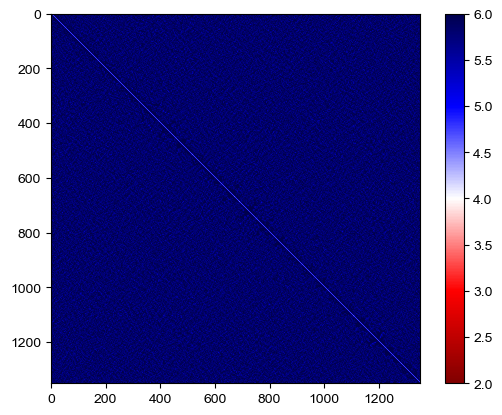

In [72]:
%matplotlib inline
fig, ax = plt.subplots()
_pf = ax.imshow(dist_mat, vmin=2, vmax=6, 
                cmap='seismic_r', interpolation=None)
plt.colorbar(_pf)
plt.show()

## append chromosome info

In [73]:
# add chromosome info
codebook['chr'] = [_n.split(':')[0] for _n in codebook['name']]
for _chr in np.unique(codebook['chr']):
    _chr_codebook = codebook.loc[codebook['chr']==_chr]
    _chr_reg_info = [np.mean([int(_loc) for _loc in _n.split(':')[1].split('-')]) for _n in _chr_codebook['name']]
    _chr_orders = np.array(_chr_reg_info).argsort().argsort().astype(np.int32)
    codebook.loc[codebook['chr']==_chr, 'chr_order'] = _chr_orders
# sort id
#codebook.sort_values('id', inplace=True)


In [94]:
codebook_save_filename = os.path.join(save_folder, 'CTP14-human_genome_codebook_probe.csv')
if not os.path.exists(codebook_save_filename):
    print(codebook_save_filename)
    codebook.to_csv(codebook_save_filename,index=None)

## Generate blanks

In [78]:
def convert_bits_to_matrix(bits):
    _matrix = np.ones([len(bits), np.max(bits)+1], dtype=np.int32) * -1
    for _i, _b in enumerate(bits):
        _matrix[_i, _b] = 1
    return _matrix

In [80]:
on_num = 3
total_num = len(readout_dict['c'])

encoding_file = os.path.join(library_folder, f'covering_v_{total_num}_k_{on_num}_t_2.txt')
loaded_barcodes = []

with open(encoding_file, 'r') as _handle:
    # start reading
    _lines = _handle.read().split('\n')
    for _line in _lines:
        _bits = [int(_i)-1 for _i in _line.split(' ') if len(_i) > 0]
        loaded_barcodes.append(_bits)

loaded_barcodes = np.array(loaded_barcodes, dtype=np.int32)
print(np.shape(loaded_barcodes))

# remove redundant barcodes
kept_barcodes = loaded_barcodes.copy()
kept_inds = np.zeros(len(kept_barcodes))
while np.sum(kept_inds) != len(kept_inds):
    kept_inds = np.ones(len(kept_barcodes), dtype=bool)
    _kept_mat = convert_bits_to_matrix(kept_barcodes)
    _dists = (total_num - (_kept_mat @ _kept_mat.T)) / 2
    _x, _y = np.where((_dists > 0) * (_dists <= 3))
    if len(_x) > 0:
        kept_inds[_x[0]] = False
        kept_barcodes = kept_barcodes[kept_inds]
        print(np.sum(kept_inds), kept_inds[_x[0]])
print(kept_barcodes.shape)

(1617, 3)
(1617, 3)


In [81]:
used_barcodes = []
for _reg, _code in region_2_readout_dict.items():
    _barcode = np.array([int(_c.split('c')[1]) for _c in _code])
    used_barcodes.append(_barcode)
used_barcodes = np.array(used_barcodes)

free_barcodes = []
for _barcode in kept_barcodes:
    if (used_barcodes == _barcode).all(1).any():
        continue
    else:
        free_barcodes.append(_barcode)

## generate a randomly selected blank

In [87]:
num_blank = 99

num_bits = len(readout_dict['c'])

blank_bit_usage = np.zeros(num_bits)
exist_bit_usage = np.zeros(num_bits)
for _b in used_barcodes:
    exist_bit_usage[_b] += 1
# init 
sel_blank_barcodes = []
# shuffle free barcodes
#np.random.shuffle(free_barcodes)
cand_barcodes = [_b for _b in free_barcodes]
while len(sel_blank_barcodes) < num_blank:
    # for each cand bit, estimate bit usage
    _bit_usages = np.array([exist_bit_usage[_c].sum() + blank_bit_usage[_c].sum() for _c in cand_barcodes])
    #_blank_bit_usages = np.array([blank_bit_usage[_c].sum() for _c in cand_barcodes])
    # randomly select one of the smallest used bits
    _min_inds = np.where(_bit_usages == np.min(_bit_usages))[0]
    _sel_min_ind = _min_inds[np.random.randint(len(_min_inds),)]
    # append
    _sel_barcode = cand_barcodes[_sel_min_ind].copy()
    sel_blank_barcodes.append(_sel_barcode)
    # pop this candidate
    cand_barcodes.pop(_sel_min_ind)
    # update usage
    blank_bit_usage[_sel_barcode] += 1
    exist_bit_usage[_sel_barcode] += 1
# check
np.unique(blank_bit_usage, return_counts=True)

(array([2., 3., 4.]), array([ 7, 85,  7], dtype=int64))

In [88]:
blank_bit_usage

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 3., 3., 3., 2., 3., 3., 3.,
       3., 3., 3., 3., 2., 3., 2., 3., 3., 3., 3., 3., 3., 3., 3., 4., 3.,
       3., 3., 3., 3., 2., 3., 3., 3., 3., 3., 3., 4., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 2., 3., 3., 4., 3., 3., 3., 4., 4., 3., 2.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 3., 3.])

## Save

In [89]:
print(save_folder)

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\Summary_tables


In [90]:
save_filename = os.path.join(save_folder, 'blank_barcodes.npy')
print(save_filename)
if not os.path.exists(save_filename):
    np.save(save_filename, np.array(sel_blank_barcodes))

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\Summary_tables\blank_barcodes.npy


In [91]:
# generate the codebook_blank
codebook_blank = pd.DataFrame(columns=['name','id']+[_r.id for _r in readout_dict['c']])
max_bit = np.max([np.max([int(_b[1:]) for _b in _bits]) for _gname, _bits in region_2_readout_dict.items()]) + 1
# decide region ids first
_id_start = np.max((codebook['id']).values.astype(np.int32))+1
codebook_blank['id'] = np.arange(_id_start, _id_start+len(sel_blank_barcodes))
# decide region names
codebook_blank['name'] = [f'B:{_i}-{_i+1}' for _i in range(len(sel_blank_barcodes))]
for _i, _name in enumerate(codebook_blank['name']):
    _barcode = sel_blank_barcodes[_i]
    binary_code = np.zeros(max_bit, dtype=np.int32)
    binary_code[_barcode] = 1
    codebook_blank.loc[codebook_blank['name']==_name, codebook_blank.columns[2:]] = binary_code
# add chromosome info
codebook_blank['chr'] = [_n.split(':')[0] for _n in codebook_blank['name']]
for _chr in np.unique(codebook_blank['chr']):
    _chr_codebook_blank = codebook_blank.loc[codebook_blank['chr']==_chr]
    _chr_reg_info = [np.mean([int(_loc) for _loc in _n.split(':')[1].split('-')]) for _n in _chr_codebook_blank['name']]
    _chr_orders = np.array(_chr_reg_info).argsort().argsort().astype(np.int32)
    codebook_blank.loc[codebook_blank['chr']==_chr, 'chr_order'] = _chr_orders

In [92]:
# Merge blank with codebook
codebook_w_blank = pd.concat([codebook,codebook_blank], ignore_index=True)
# sanity check
np.unique(codebook_w_blank.values[:,2:-2].astype(int).sum(1))

array([3])

In [95]:
codebook_blank_save_filename = os.path.join(save_folder, 'CTP14-human_genome_codebook_probe_w_blank.csv')
if not os.path.exists(codebook_blank_save_filename):
    print(codebook_blank_save_filename)
    codebook_w_blank.to_csv(codebook_blank_save_filename,index=None)

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\Summary_tables\CTP14-human_genome_codebook_probe_w_blank.csv
